<a href="https://colab.research.google.com/github/aniketmishr/ml-tutorial/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
class Neuron:
  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  def __call__(self,x):
    p = sum([xi*wi for xi,wi in zip(x ,self.w)]) + self.b
    o = p.tanh()
    return o
  def parameters(self):
    return self.w + [self.b]

In [ ]:
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  def parameters(self):
    params = []
    for neuron in self.neurons:
      params.extend(neuron.parameters())
    return params

In [ ]:
class MLP:
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts)) ]
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    params = []
    for layer in self.layers:
      params.extend(layer.parameters())
    return params

In [ ]:
## a very simple dataset to train our neural net
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0,-1.0,-1.0,1.0]


In [ ]:
nn = MLP(3,[4,4,1])


In [ ]:
ypred = [nn(x) for x in xs]
ypred

[Value(data=0.1772997365416886),
 Value(data=0.7430749627375162),
 Value(data=0.4198202766877699),
 Value(data=0.6731667119863519)]

In [ ]:
# calculating loss to calculate the accuracy the neural net
loss =sum([(yout - ygt)**2 for  ygt , yout in  zip(ys, ypred) ])
loss # starting loss value

Value(data=5.837855665464316)

In [ ]:
loss.backward()

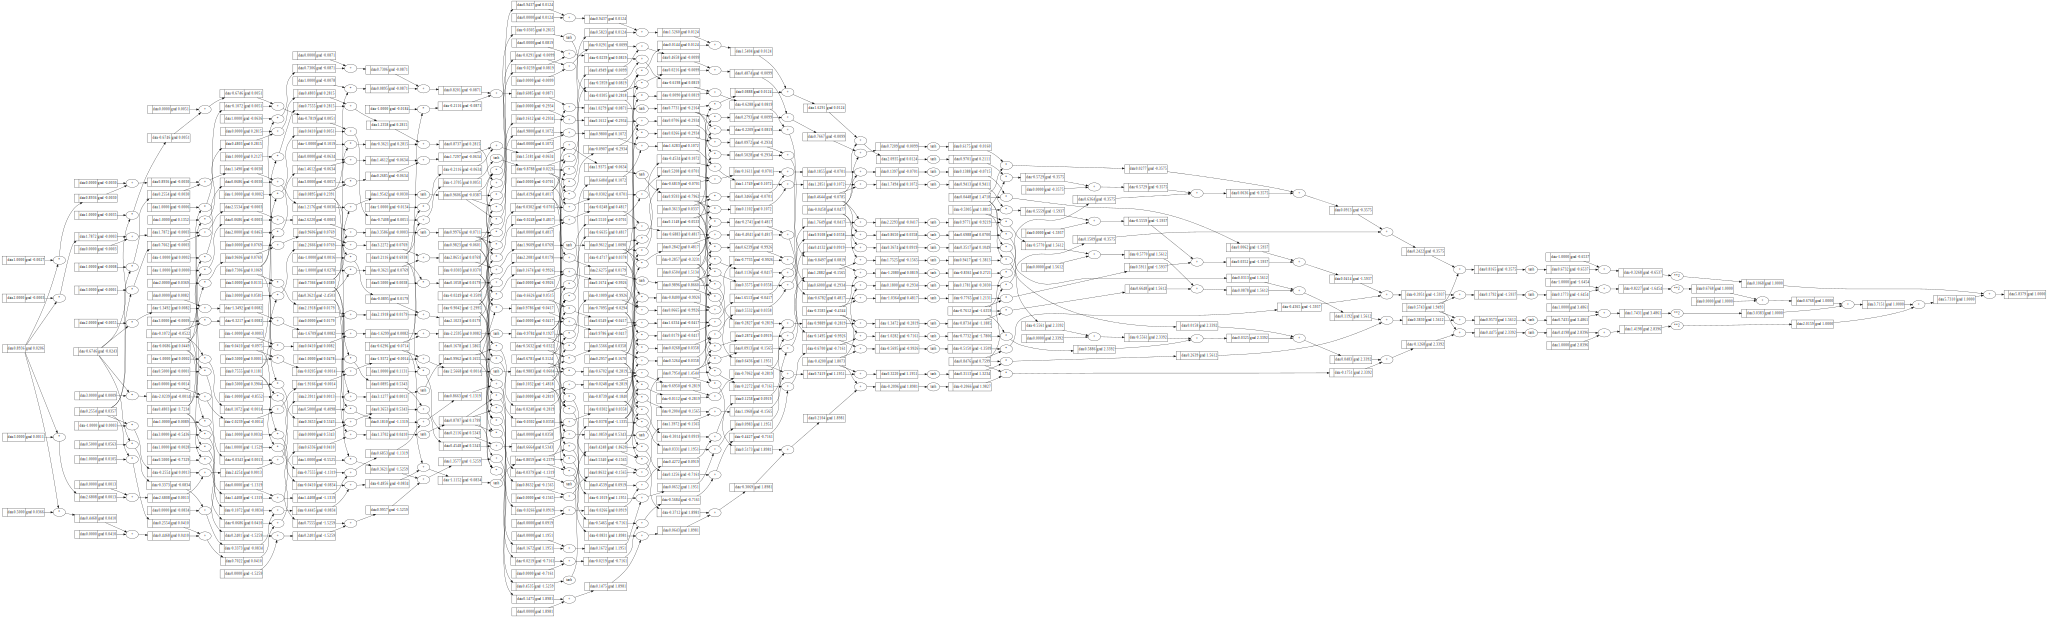

In [ ]:
draw_dot(loss)

In [ ]:
nn.parameters() # total 41 parameters

[Value(data=0.8936034292290698),
 Value(data=0.25539202729701604),
 Value(data=-0.06861939106933379),
 Value(data=0.7366009609707382),
 Value(data=-0.6746220110836676),
 Value(data=-0.1072304832905926),
 Value(data=-0.041034017000098455),
 Value(data=-0.6296358475130646),
 Value(data=0.4802784779720042),
 Value(data=0.7555343276069275),
 Value(data=0.362075942164243),
 Value(data=-0.9041998479512758),
 Value(data=0.7305872421364195),
 Value(data=0.08950500994772548),
 Value(data=0.2116299044593608),
 Value(data=0.41944201915021284),
 Value(data=0.9823325167062211),
 Value(data=-0.6626387545432235),
 Value(data=-0.4717481759832256),
 Value(data=0.1148365993545517),
 Value(data=0.46437008378116373),
 Value(data=-0.024874797417644645),
 Value(data=0.678138786426935),
 Value(data=0.2957296790730377),
 Value(data=-0.2856950298543215),
 Value(data=-0.3582646272163872),
 Value(data=-0.03029831469325761),
 Value(data=-0.5631627641840644),
 Value(data=-0.7094609134369689),
 Value(data=0.3612963

In [ ]:
epochs = 20
lr = 0.05
for i in range(epochs):
  ## Forward Pass
  ypred = [nn(x) for x in xs]
  loss =sum([(yout - ygt)**2 for  ygt , yout in  zip(ys, ypred) ])

  ## BackPropagation
  for p in nn.parameters():
    p.grad = 0.0
  loss.backward()

  ## Updating Weigths and bias

  for p in nn.parameters():
    p.data += -lr*p.grad

  print(f"Epochs {i} : Loss Value -> ",loss.data)

Epochs 0 : Loss Value ->  5.837855665464316
Epochs 1 : Loss Value ->  3.8598029988374183
Epochs 2 : Loss Value ->  3.5206242221457233
Epochs 3 : Loss Value ->  3.293684857549088
Epochs 4 : Loss Value ->  3.099970393679658
Epochs 5 : Loss Value ->  2.932882746667724
Epochs 6 : Loss Value ->  2.770306785761681
Epochs 7 : Loss Value ->  2.563081680565482
Epochs 8 : Loss Value ->  2.087801565895939
Epochs 9 : Loss Value ->  1.04016096786416
Epochs 10 : Loss Value ->  0.5784822046602194
Epochs 11 : Loss Value ->  0.3801778644794977
Epochs 12 : Loss Value ->  0.21314638805603092
Epochs 13 : Loss Value ->  0.17895440183895572
Epochs 14 : Loss Value ->  0.1537996153893344
Epochs 15 : Loss Value ->  0.1342797475858458
Epochs 16 : Loss Value ->  0.1187349969058245
Epochs 17 : Loss Value ->  0.10610771037282855
Epochs 18 : Loss Value ->  0.0956793003674522
Epochs 19 : Loss Value ->  0.0869443067732634


In [ ]:
print([p.data for p in ypred])
print('\n')
print(ys)

[0.8470468278180074, -0.8603387403311414, -0.844319168624541, 0.8592596533232821]


[1.0, -1.0, -1.0, 1.0]
